<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In order to simulate aleternative control strategies a hot water cylinder environment that approximates the operation under real world conditions is required. There are a large number of models of varying numerical complexity that were reviewed such as:

[Model Predictive Control of Heat Pump Water Heaters for Energy Efficiency](https://www.aceee.org/files/proceedings/2014/data/papers/1-296.pdf)

[Dynamic modeling of a sensible thermal energy storage tank with an
immersed coil heat exchanger under three operation modes](https://engineering.purdue.edu/JainResearchLab/pdf/dynamic-modeling-sensible-thermal-energy-storage-immersed-coil-heat-exchanger.pdf)

These models have been developed to incorporate stratification and internal heat transfer however a simple energy balance model was selected with the addition of an internal conduction variable to decay the stratified layer.

[A minimal simulation of the electricity demand of a domestic hot water
cylinder for smart control](https://sci-hub.se/10.1016/j.apenergy.2017.11.044)
 

\section{Nomenclature}

$\Delta \quad$ internal heat transfer scaling parameter

$\dot{m}_{c} \quad$ mass flow rate of IHX coil fluid

$\dot{m}_{c w} \quad$ mass flow rate of inlet domestic cold water

$\dot{m}_{t} \quad$ discharge mass flow rate through tank

$\dot{Q}_{\text {coil }} \quad$ heat transfer rate due to IHX coil

$\dot{Q}_{j+1}$ heat transfer rate between nodes $j$ and $j+1$

$\dot{Q}_{j-1} \quad$ heat transfer rate between nodes $j$ and $j-1$

$\dot{Q}_{\text {wall }}$ heat transfer rate for losses to surroundings

A cross-sectional area of node control volume

$A_{w} \quad$ wall contact surface area

$c_{v} \quad$ specific heat capacity of water

$j \quad$ current node in iterative energy equations

$j+1 \quad$ represents node below node $j$

$\begin{array}{ll}j-1 & \text { represents node above node } j \\ k & \text { internal node interaction heat transfer coefficient } \\ k_{w} & \text { lumped heat transfer coefficient for losses across walls } \\ m & \text { mass of node } \\ s_{1} & \text { discharge fluid correction factor } \\ T & \text { temperature } \\ t & \text { time } \\ T_{c w} & \text { domestic cold water temperature } \\ T_{e n} & \text { IHX coil fluid inlet temperature } \\ T_{e x} & \text { IHX coil fluid outlet temperature } \\ w_{t} & \text { tank wall thickness } \\ z & \text { vertical height variable with respect to tank bottom }\end{array}$

In [1]:
#| echo: false
#| output: asis
show_doc(HWC)

---

[source](https://github.com/CJP123/cylinder/blob/main/cylinder/hwc_2node.py#L16){target="_blank" style="float:right; font-size:smaller"}

### HWC

>      HWC (element=3, T_set=75, T_deadband=2, T_cold=15, T_inlet=15,
>           radius=0.25, height=1.1, K=0.05, U=0.8, noisey=True)

Model of a Hot Water Cylinder using a nodal approach.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| element | int | 3 | kW |
| T_set | int | 75 | °C |
| T_deadband | int | 2 | °C |
| T_cold | int | 15 | °C |
| T_inlet | int | 15 | °C |
| radius | float | 0.25 | m |
| height | float | 1.1 | m |
| K | float | 0.05 | m |
| U | float | 0.8 |  |
| noisey | bool | True |  |

![HWC](images/hwc.png)

In [ ]:
env = HWC(T_set=55, element=3)
temp = []
for step in range(60):
    env._update_model(action = 1, flow = 0)
    # temp0.append(env.temperatures[0])    
    temp.append(env.temperatures.copy())
    # print(env.temperatures, env.z, env.stratified)
# env.step(flow=0.03)
# print(env.temperatures, env.z, env.stratified)
# env.step(action=1,flow=0)
# print(env.temperatures, env.z, env.stratified)
# env.step(action=1)
# print(env.temperatures, env.z, env.stratified)

In [ ]:
expected_temp_rise = 3 / (env.volume * env.ρ * env.Cv) * 60 *60
wall_losses =  env.surface_area * env.U * (np.vstack(temp).mean() - env.T_ambient) * 60/1000 # countinuous load in W x h
print(wall_losses)
print(f'Expected temperature rise = {expected_temp_rise:.1f}')
print(f'Model temperature change = {temp[-1].mean() - temp[0].mean():.1f}°C')

0.07034997945196131
Expected temperature rise = 12.0
Model temperature change = 11.7°C


In [ ]:
expected_temp_rise = 3 / (env.volume * env.ρ * env.Cv) * 60 *60
wall_losses =  env.surface_area * env.U * (np.vstack(temp).mean() - env.T_ambient) * 60/1000 # countinuous load in W x h
print(f'Expected temperature rise = {expected_temp_rise-wall_losses:.1f}')
print(f'Model temperature change = {temp[-1].mean() - temp[0].mean():.1f}°C')

Expected temperature rise = 11.9
Model temperature change = 11.7°C


# Model Operation

## Initialisation

Text(0.5, 0.98, 'Random initial states of charge for 10 different models')

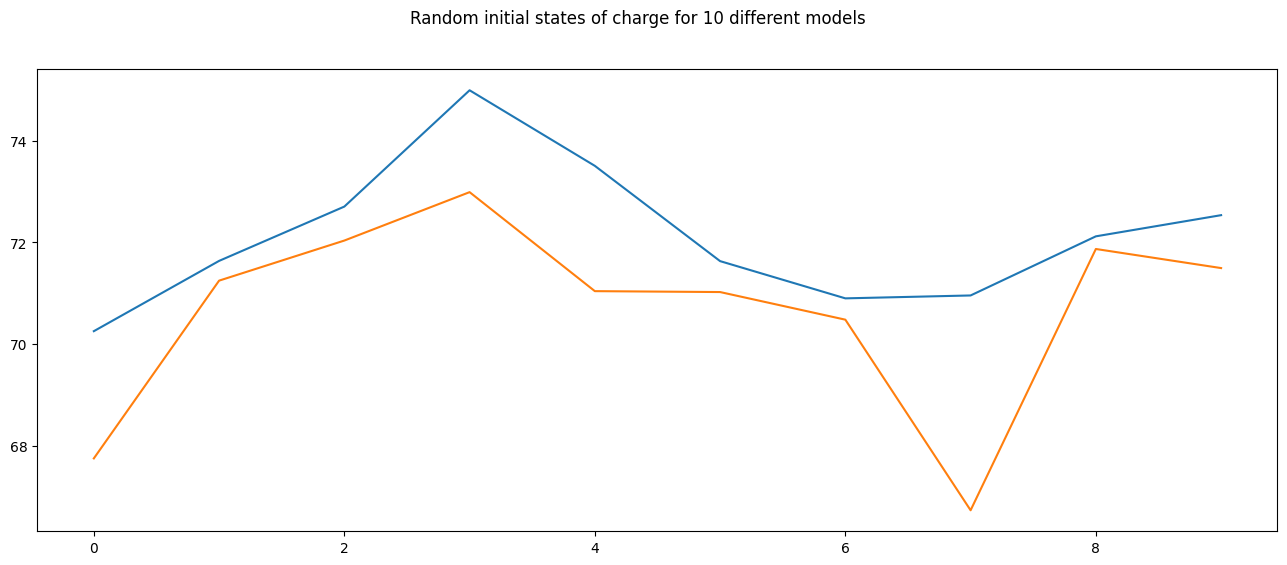

In [ ]:
temp = []
for i in range(10):
    env = HWC(T_set=75, element=3)
    temp.append(env.temperatures)
    assert env.temperatures[0]<= 75.5
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
fig.suptitle('Random initial states of charge for 10 different models')

In [ ]:
env = HWC(T_set=75, element=3, height=1, radius=.5)
# check that the volume and areas are correct
assert env.volume == np.pi/4
assert env.A == np.pi/4

## Passive Losses - No Heating + No Flow

In [ ]:
env = HWC(T_set=55, element=3, radius=.25, U=1)
temp = []
minutes = 60*24
for minute in range(minutes):
    env._update_model(action = 0 , flow = 0)
    temp.append(env.temperatures)

### Compare to calulation from first principles

In [ ]:
mean_cylinder_temperature = (np.vstack(temp)* env.split).sum(axis=1).mean()
passive_real =   env.U * env.surface_area * (mean_cylinder_temperature - env.T_ambient) # kW/m2K x m2 x K  = KW
passive_real =   passive_real * 60 * 24 / 1000 # kWh per day

model_losses =   env.volume * env.ρ * env.Cv * ((temp[0]* env.split).sum()- (temp[-1]* env.split).sum()) / 1000 
print(f'Calculated Passive losses: {passive_real/24:.2f} kWh / hour and a total of {passive_real:.2f} kWh / day')

print(f'Model Losses:  minutes {model_losses:.2f} kWh / hour and a total of {model_losses:.2f} kWh / day')

Calculated Passive losses: 0.08 kWh / hour and a total of 1.88 kWh / day
Model Losses:  minutes 0.00 kWh / hour and a total of 0.00 kWh / day


Text(0.5, 0.98, 'Passive Losses - No Heating + No Flow over 1440 minutes')

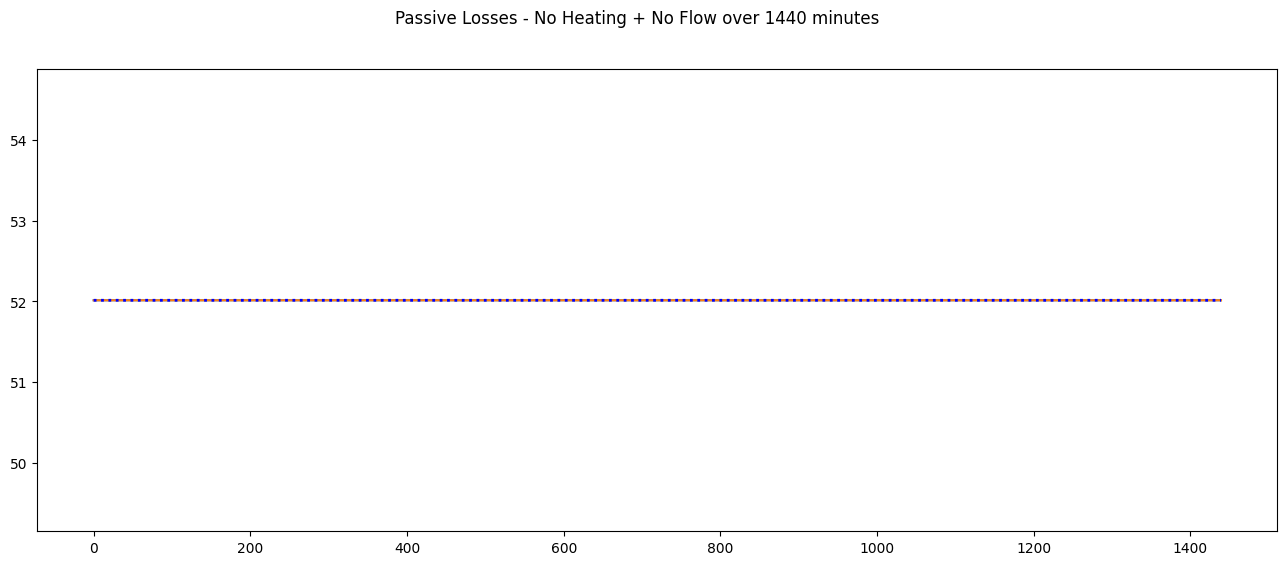

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot((np.vstack(temp)*env.split).sum(axis=1), lw=2, ls=':', c='blue')
fig.suptitle(f'Passive Losses - No Heating + No Flow over {minutes} minutes')

The standing heat loss for a tank should be in the order of 1.7 kWh / day for a tank at 55 degrees. https://sustainableengineering.co.nz/portfolio-item/dhw-tanks-w-k-from-kwh-day/

## No Heating + Flow rate of 10 litres per minure for 10 minutes

Text(0.5, 0.98, 'No Heating + Flow rate of 10 litres per minure for 10 minutes')

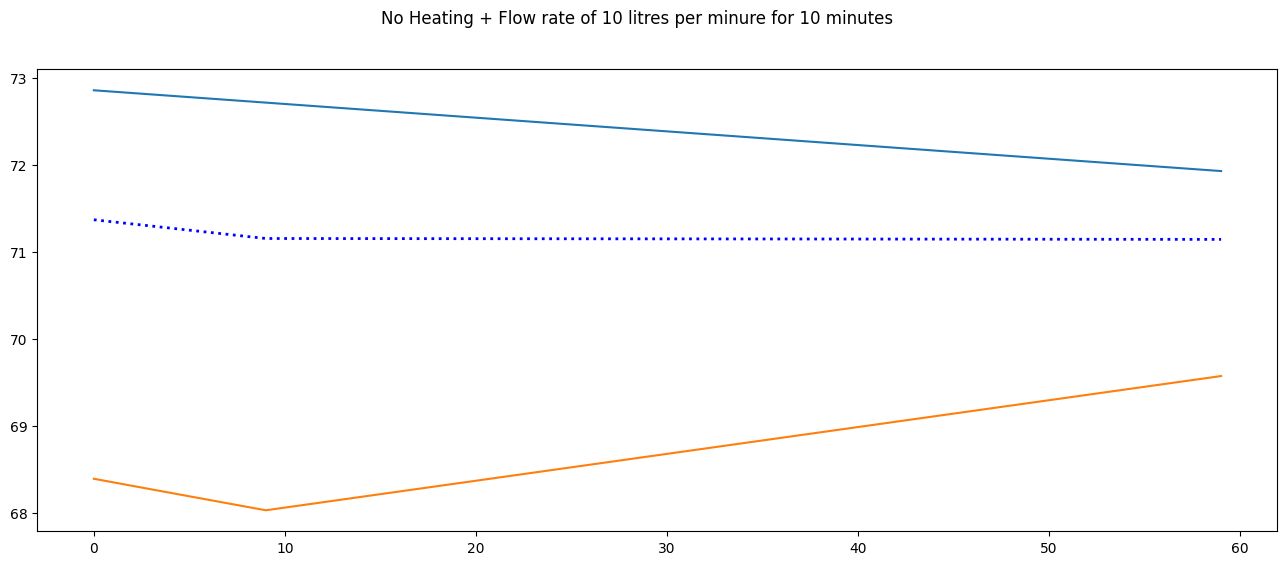

In [ ]:
env = HWC(T_set=75, element=3)
flow = 10/60/1000 # 10 litres per minute
temp = []
minutes = 60
for minute in range(minutes):
    action = 0 #np.random.randint(0,2)
    env._update_model(action = action , flow = flow if minute < 10 else 0)
    temp.append(env.temperatures.copy())

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot((np.vstack(temp)*env.split).sum(axis=1), lw=2, ls=':', c='blue')

fig.suptitle('No Heating + Flow rate of 10 litres per minure for 10 minutes')

# Heating Bottom Element + No Flow

Text(0.5, 0.98, 'dd')

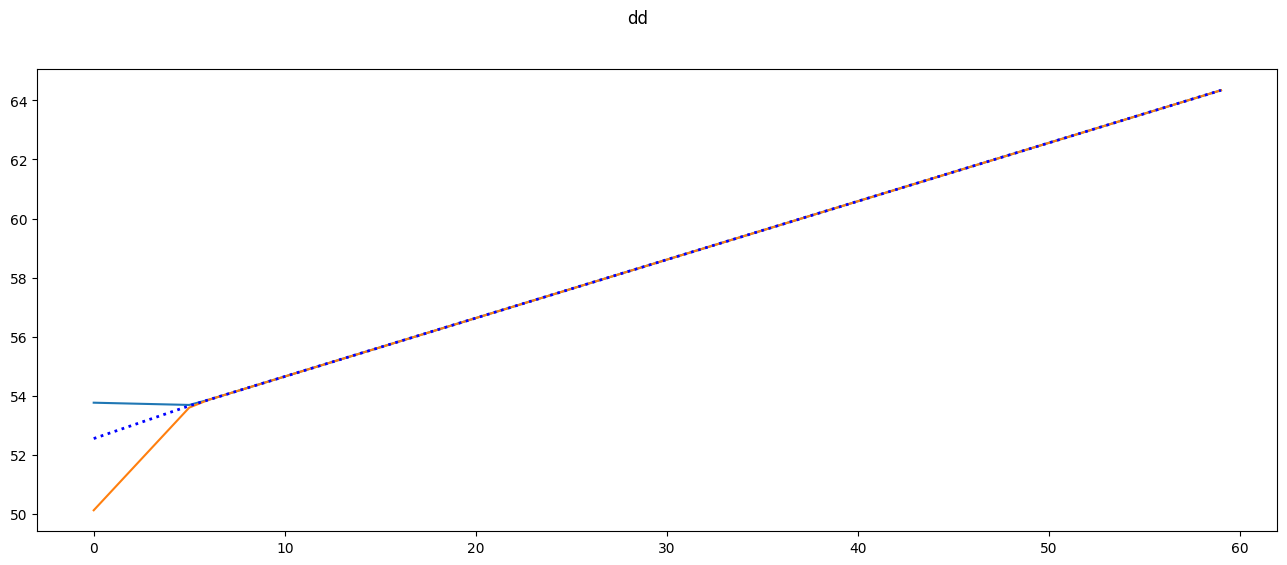

In [ ]:
env = HWC(T_set=55, element=3)
temp = []
minutes = 60
for minute in range(minutes):
    env._update_model(action = 1 , flow = 0)
    temp.append(env.temperatures.copy())

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot((np.vstack(temp)*env.split).sum(axis=1), lw=2, ls=':', c='blue')

fig.suptitle('dd')

In [ ]:
# In 1 hour
Tfinal = 3600 * env.element / (env.volume * env.ρ * env.Cv) + temp[0].mean()
print(f'Expected temperature rise = {Tfinal:.1f}')
print(f'Model final temperature = {(temp[-1]*env.split).sum():.1f}°C')

Expected temperature rise = 63.9
Model final temperature = 64.3°C
